<a href="https://colab.research.google.com/github/seplanas/Regresion-no-lineal/blob/main/actividad_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.special as special
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('/content/cuentas_credicel.csv',
                 encoding = 'latin')

<ipython-input-2-71e76e9bd8d6>:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/cuentas_credicel.csv',


In [3]:
#sns.pairplot(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22735 entries, 0 to 22734
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   folio               22735 non-null  int64  
 1   tag                 22735 non-null  object 
 2   folio_solicitud     22735 non-null  int64  
 3   fecha               22735 non-null  object 
 4   marca               22735 non-null  object 
 5   modelo              22735 non-null  object 
 6   plazo               22735 non-null  object 
 7   precio              22735 non-null  float64
 8   enganche            22735 non-null  float64
 9   descuento           22735 non-null  float64
 10  semana              22735 non-null  int64  
 11  monto_financiado    22735 non-null  float64
 12  costo_total         22735 non-null  int64  
 13  monto_accesorios    22735 non-null  float64
 14  agente_venta        22735 non-null  object 
 15  dis_venta           22735 non-null  object 
 16  stat

In [5]:
df.head(5)

folio       tag  folio_solicitud           fecha     marca  \
0      3  HDNAWQ3A               30  12/11/21 19:00       ZTE   
1      4  M418YNR4               33  12/11/21 19:15  MOTOROLA   
2      5  SZ7V3NZT               37  13/11/21 14:13       ZTE   
3      6  9I08UIQZ               38  13/11/21 15:45       ZTE   
4      7  JMF4LKYU               44  13/11/21 16:10  MOTOROLA   

                         modelo plazo  precio  enganche  descuento  ...  \
0            Blade A3 2020 RO B   26S  1949.0     780.0        0.0  ...   
1  LTE XT2097-12 E7I POWER Azul   13S  2999.0    1050.0        0.0  ...   
2            BLADE A3 2020 Gris   13S  1959.0     490.0        0.0  ...   
3            BLADE A3 2020 Gris   13S  1959.0     490.0        0.0  ...   
4                         G10 B   39S  4299.0    1075.0        0.0  ...   

   porc_eng  limite_credito  semana_actual  cp_cliente edad_cliente  \
0     40.02            5000             26         NaN         23.0   
1     35.01            6000             13         NaN         60.0   
2     25.01               0             74         NaN         58.0   
3     25.01            7000             13         NaN         42.0   
4     25.01            7000             74         NaN         33.0   

    cd_cliente  edo_cliente                    cd_venta edo_venta  \
0            0            0                   Tantoyuca  Veracruz   
1      PUEBLA          PUE.  Heroica Puebla de Zaragoza    Puebla   
2    TANTOYUCA         VER.                           0         0   
3  AMXTLAN PUE          NaN                    Zacatlan    Puebla   
4   TANTOYUCA          VER.                   Tantoyuca  Veracruz   

                 curp  
0  AEVM980413MVZNDR02  
1  ZALC610119MPLPRR07  
2                   0  
3  SAMJ790115MPLNRS02  
4  TEHF880707HVZRRR07  

[5 rows x 39 columns]

**variables objetivo:**

*   Riesgo (float)
*   score_buro(int)
*   porc_eng(float)
*   limite_credito(object) - Es necesario cambiarlo a número





In [6]:
#df = df[df['limite_credito'] != "SD"]
#df['limite_credito'] = df['limite_credito'].str.replace(' ', '')
#df['limite_credito'] = df['limite_credito'].astype(float)


In [7]:
df['limite_credito'] = df['limite_credito'].str.extract('(\d+\.\d+|\d+)').astype(float)

In [8]:
print(df['limite_credito'])

0        5000.0
1        6000.0
2           0.0
3        7000.0
4        7000.0
          ...  
22730       NaN
22731       NaN
22732       NaN
22733       NaN
22734       NaN
Name: limite_credito, Length: 22735, dtype: float64


In [9]:
numeric = df.select_dtypes(include=['float64', 'int64']).columns

In [10]:
df = df[numeric]

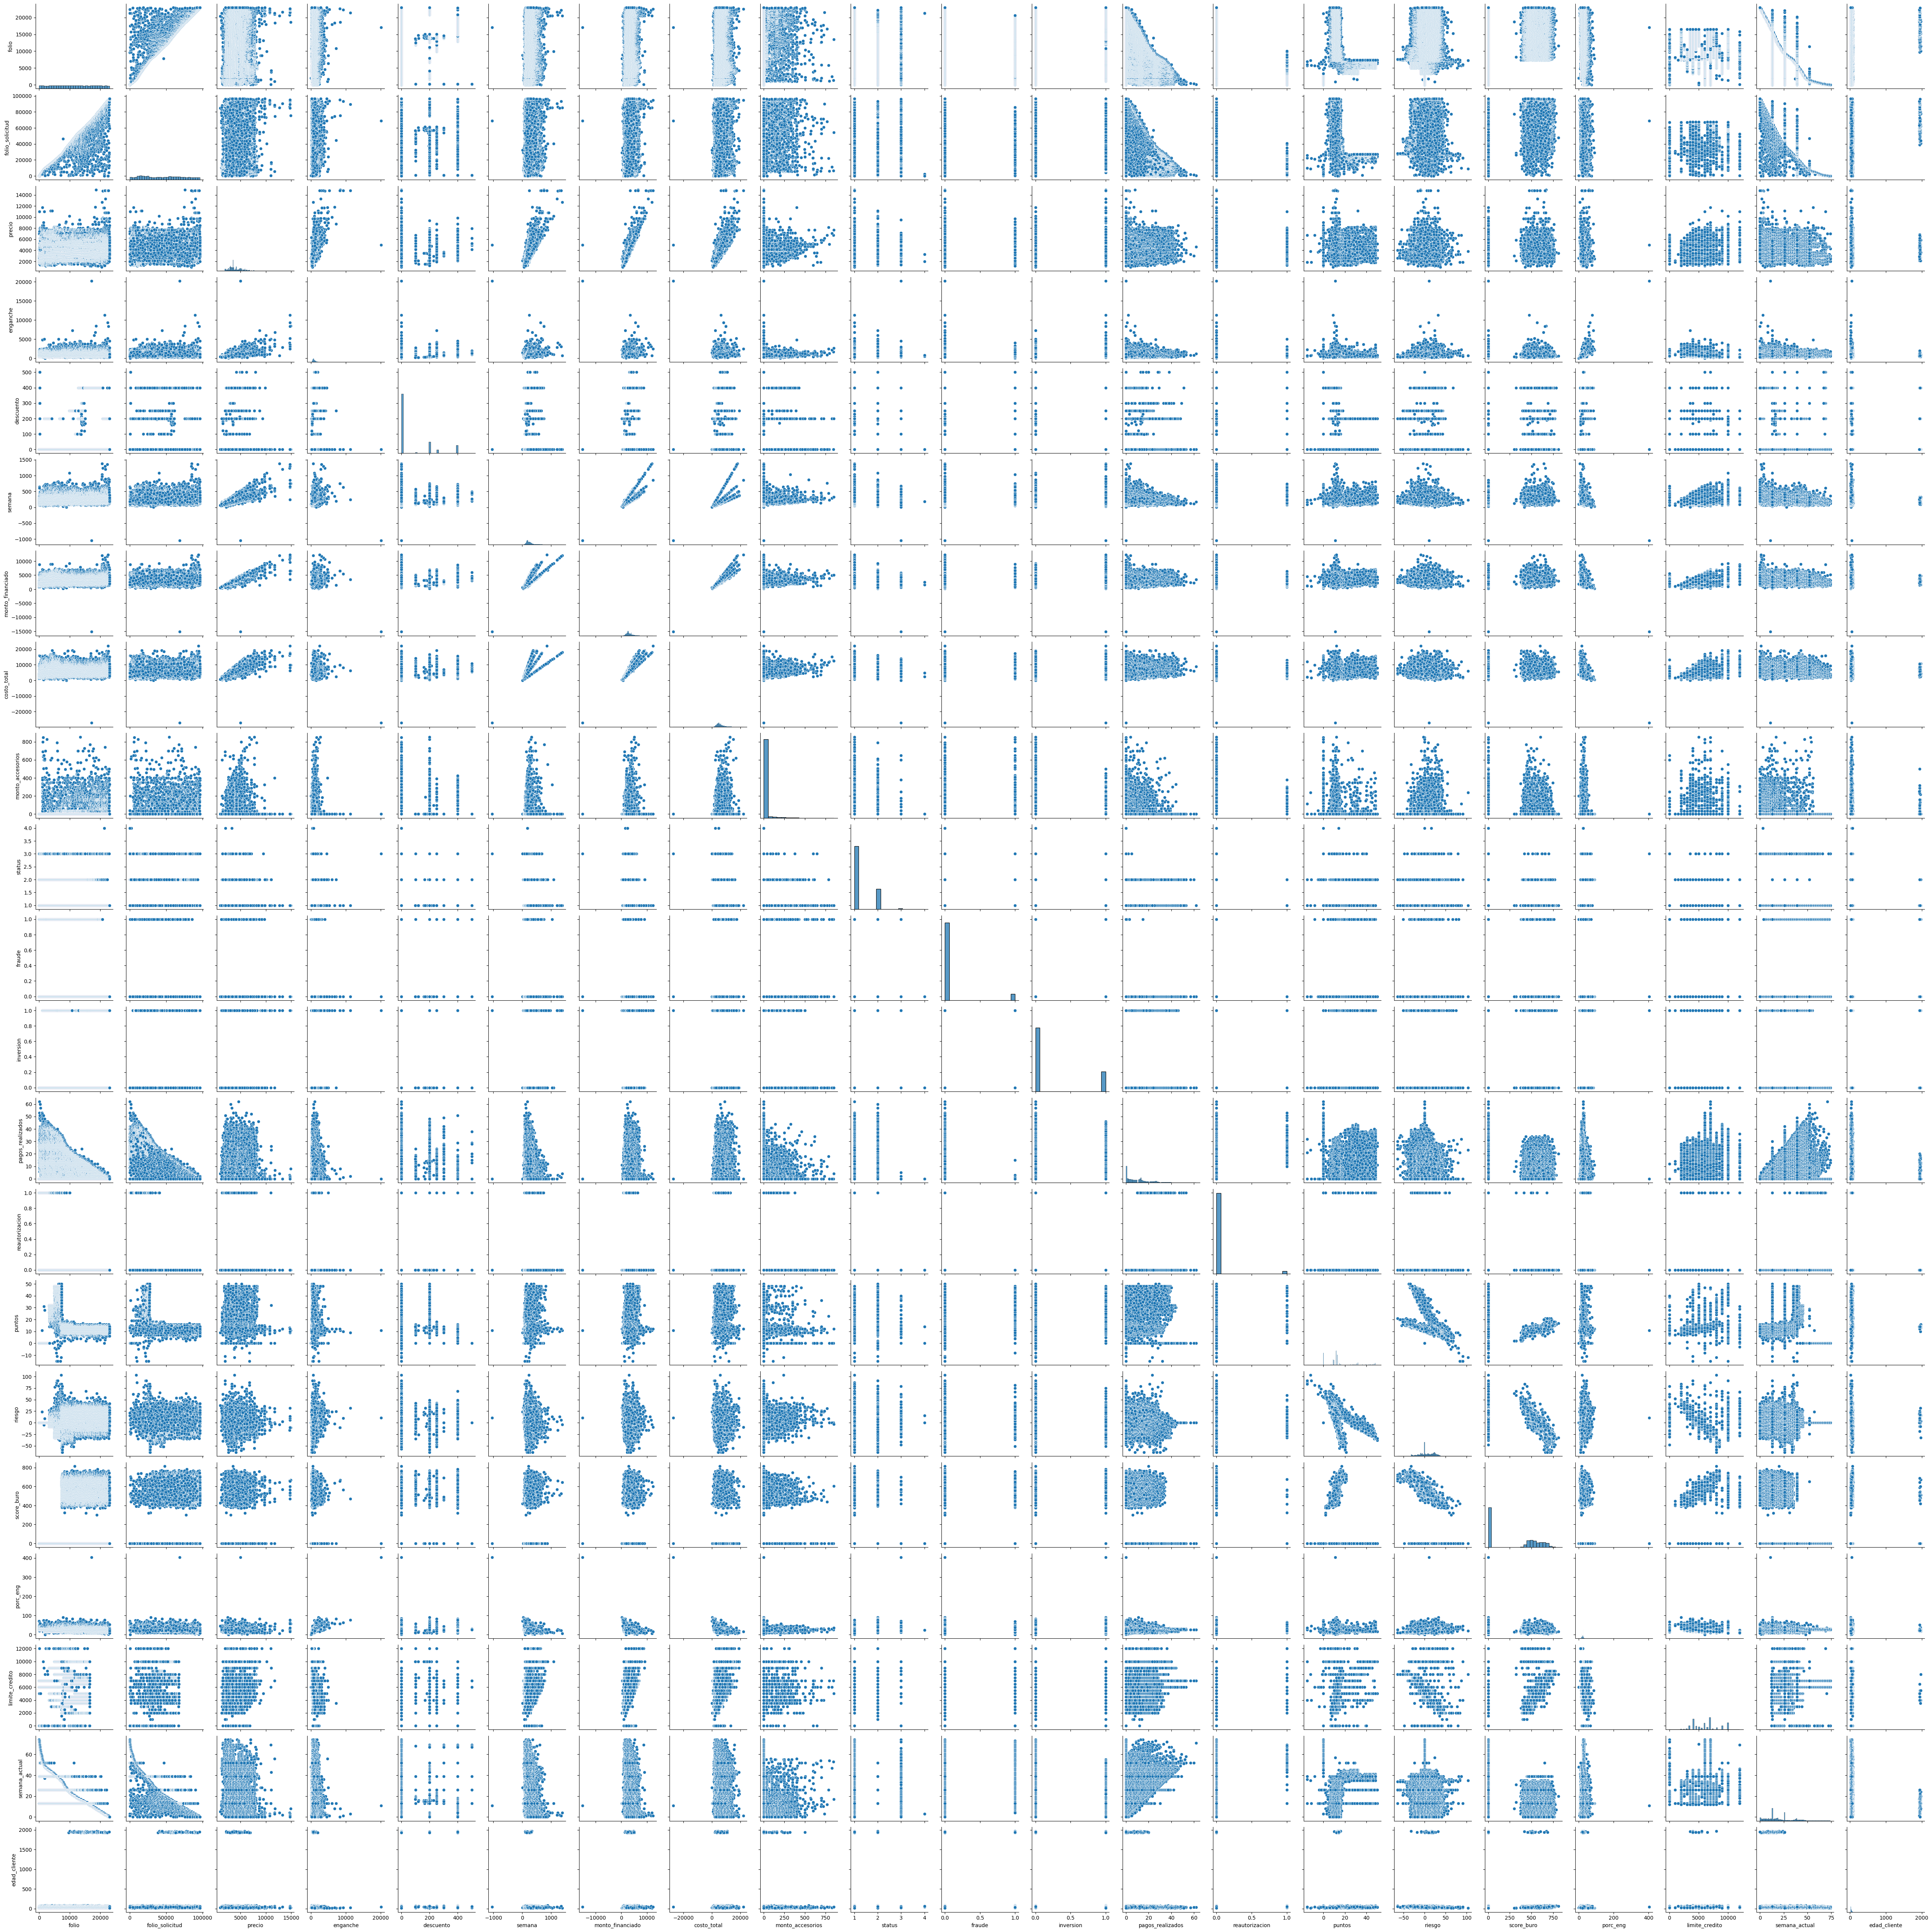

In [11]:
sns.pairplot(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22735 entries, 0 to 22734
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   folio             22735 non-null  int64  
 1   folio_solicitud   22735 non-null  int64  
 2   precio            22735 non-null  float64
 3   enganche          22735 non-null  float64
 4   descuento         22735 non-null  float64
 5   semana            22735 non-null  int64  
 6   monto_financiado  22735 non-null  float64
 7   costo_total       22735 non-null  int64  
 8   monto_accesorios  22735 non-null  float64
 9   status            22735 non-null  int64  
 10  fraude            22735 non-null  int64  
 11  inversion         22735 non-null  int64  
 12  pagos_realizados  22735 non-null  int64  
 13  reautorizacion    22735 non-null  int64  
 14  puntos            22735 non-null  int64  
 15  riesgo            22735 non-null  float64
 16  score_buro        22735 non-null  int64 

In [13]:
#valores para limpieza

valores = [
    'precio',
    'enganche',
    'descuento',
    'monto_financiado',
    'costo_total',
    'monto_accesorios',
    'status',
    'fraude',
    'inversion',
    'pagos_realizados',
    'reautorizacion',
    'puntos',
    'edad_cliente',
    'riesgo',   #obj
    'score_buro',     #obj
    'porc_eng',   #obj
    'limite_credito'   #obj
]

In [14]:
def nulos(valordf):
  median_val = df[valordf].median()
  df[valordf] = df[valordf].fillna(median_val)

for i in valores:
  nulos(i)

In [15]:
valores_nulos=df.isnull().sum()
print(valores_nulos)

folio               0
folio_solicitud     0
precio              0
enganche            0
descuento           0
semana              0
monto_financiado    0
costo_total         0
monto_accesorios    0
status              0
fraude              0
inversion           0
pagos_realizados    0
reautorizacion      0
puntos              0
riesgo              0
score_buro          0
porc_eng            0
limite_credito      0
semana_actual       0
edad_cliente        0
dtype: int64


##**Outliers**

In [16]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7653 entries, 3296 to 22732
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   folio             7653 non-null   int64  
 1   folio_solicitud   7653 non-null   int64  
 2   precio            7653 non-null   float64
 3   enganche          7653 non-null   float64
 4   descuento         7653 non-null   float64
 5   semana            7653 non-null   int64  
 6   monto_financiado  7653 non-null   float64
 7   costo_total       7653 non-null   int64  
 8   monto_accesorios  7653 non-null   float64
 9   status            7653 non-null   int64  
 10  fraude            7653 non-null   int64  
 11  inversion         7653 non-null   int64  
 12  pagos_realizados  7653 non-null   int64  
 13  reautorizacion    7653 non-null   int64  
 14  puntos            7653 non-null   int64  
 15  riesgo            7653 non-null   float64
 16  score_buro        7653 non-null   int6

##**Análisis de correlaciones**

In [18]:
#Definir todas las funciones en python

def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

def sinusoidal_function(x, a, b):
    return a * np.sin(x) + b

def tangential_function(x, a, b):
    return a * np.tan(x) + b

def absolute_value_function(x, a, b, c):
    return a * np.abs(x) + b * x + c

def linear_with_product_function(x, a, b, c):
    return (a * x + b) * x + c * x


In [19]:
Vars_Indep1 = 'puntos'
Vars_Indep2 = 'semana_actual'
Vars_Indep3 = 'costo_total'
Vars_Indep4 = 'pagos_realizados'

Var_dep1 = 'riesgo'
Var_dep2 = 'score_buro'
Var_dep3 = 'porc_eng'
Var_dep4 = 'limite_credito'

resultados = []

In [20]:
#función cuadrática

def modelo1(vardep, varindep):
    x = df[varindep]
    y = df[vardep]

    parametros, _ = curve_fit(quadratic_function, x, y)
    a, b, c = parametros[0], parametros[1], parametros[2]

    yfit1 = quadratic_function(x, a, b, c)

    #Gráfica
    plt.plot(x, y, 'bo', label="y-original")
    plt.plot(x, yfit1, label=f"{a:.2f} * x^2 + {b:.2f} * x + {c:.2f}")
    plt.xlabel(varindep)
    plt.ylabel(vardep)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    R2 = r2_score(y, yfit1)
    print("El valor de R2 es de:", R2)
    corr = np.sqrt(abs(R2))
    print("El valor de la correlación es de:", corr)

    resultados.append((vardep, varindep, R2, corr))

In [21]:
#modelo de función sinoidal

def modelo2(vardep, varindep):
    x = df[varindep]
    y = df[vardep]

    parametros, _ = curve_fit(sinusoidal_function, x, y)
    a, b = parametros[0], parametros[1]

    yfit1 = sinusoidal_function(x, a, b)

    #Gráfica
    plt.plot(x, y, 'bo', label="y-original")
    plt.plot(x, yfit1, label=f"{a:.2f} * sin(x) + {b:.2f}")
    plt.xlabel(varindep)
    plt.ylabel(vardep)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    R2 = r2_score(y, yfit1)
    print("El valor de R2 es de:", R2)
    corr = np.sqrt(abs(R2))
    print("El valor de la correlación es de:", corr)

    resultados.append((vardep, varindep, R2, corr))

In [22]:
#Modelo de función de valor absoluto

def modelo3(vardep, varindep):
    x = df[varindep]
    y = df[vardep]

    parametros, _ = curve_fit(absolute_value_function, x, y)
    a, b, c = parametros[0], parametros[1], parametros[2]

    yfit1 = absolute_value_function(x, a, b, c)

    #Gráfica
    plt.plot(x, y, 'bo', label="y-original")
    plt.plot(x, yfit1, label=f"{a:.2f} * abs(x) + {b:.2f} * x + {c:.2f}")
    plt.xlabel(varindep)
    plt.ylabel(vardep)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    R2 = r2_score(y, yfit1)
    print("El valor de R2 es de:", R2)
    corr = np.sqrt(abs(R2))
    print("El valor de la correlación es de:", corr)

    resultados.append((vardep, varindep, R2, corr))

In [23]:
#Modelo de función tangencial

def modelo4(vardep, varindep):
    x = df[varindep]
    y = df[vardep]

    parametros, _ = curve_fit(tangential_function, x, y)
    a, b= parametros[0], parametros[1]

    #def tangential_function(x, a, b):
    #return a * np.tan(x) + b

    yfit1 = tangential_function(x, a, b)

    #Gráfica
    plt.plot(x, y, 'bo', label="y-original")
    plt.plot(x, yfit1, label=f"({a:.2f} * tan(x) + {b:.2f})")
    plt.xlabel(varindep)
    plt.ylabel(vardep)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    R2 = r2_score(y, yfit1)
    print("El valor de R2 es de:", R2)
    corr = np.sqrt(abs(R2))
    print("El valor de la correlación es de:", corr)

    resultados.append((vardep, varindep, R2, corr))

In [24]:
#Modelo de función lineal con producto

def modelo5(vardep, varindep):
    x = df[varindep]
    y = df[vardep]

    parametros, _ = curve_fit(linear_with_product_function, x, y)
    a, b, c = parametros[0], parametros[1], parametros[2]

    yfit1 = linear_with_product_function(x, a, b, c)

    #Gráfica
    plt.plot(x, y, 'bo', label="y-original")
    plt.plot(x, yfit1, label=f"({a:.2f} * x + {b:.2f}) * x + {c:.2f} * x")
    plt.xlabel(varindep)
    plt.ylabel(vardep)
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    R2 = r2_score(y, yfit1)
    print("El valor de R2 es de:", R2)
    corr = np.sqrt(abs(R2))
    print("El valor de la correlación es de:", corr)

    resultados.append((vardep, varindep, R2, corr))

###**Análisis por pares de variables**

###Precio vs riesgo

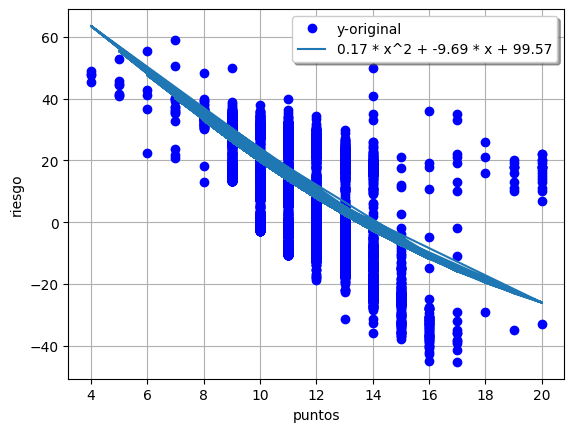

El valor de R2 es de: 0.3205925076636147
El valor de la correlación es de: 0.5662088904844348


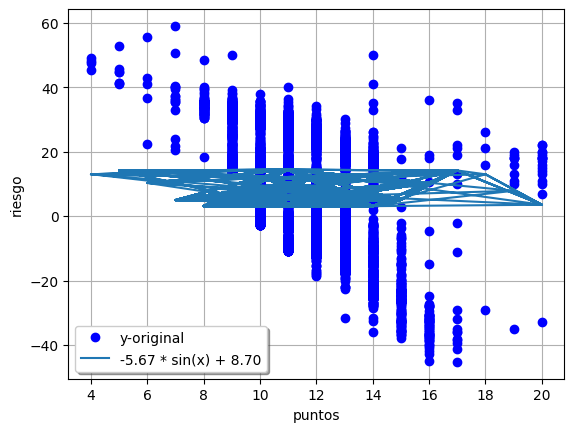

El valor de R2 es de: 0.0531082334028351
El valor de la correlación es de: 0.23045223670607995


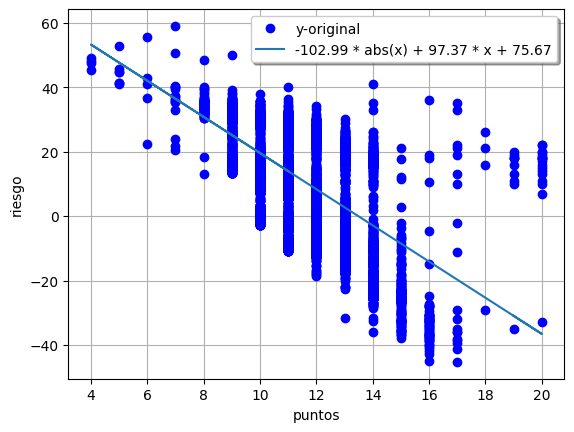

El valor de R2 es de: 0.31729860817440025
El valor de la correlación es de: 0.5632926487842711


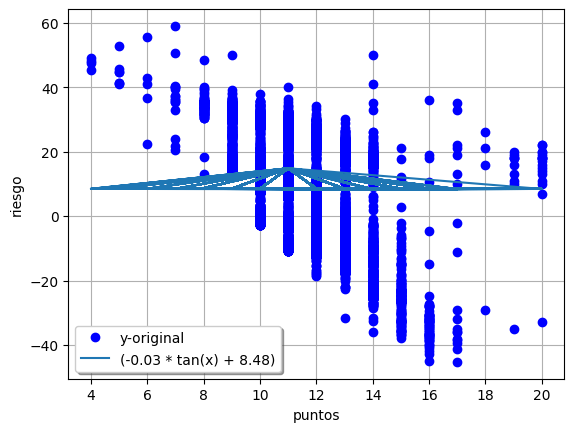

El valor de R2 es de: 0.02974100370909294
El valor de la correlación es de: 0.17245580219027987


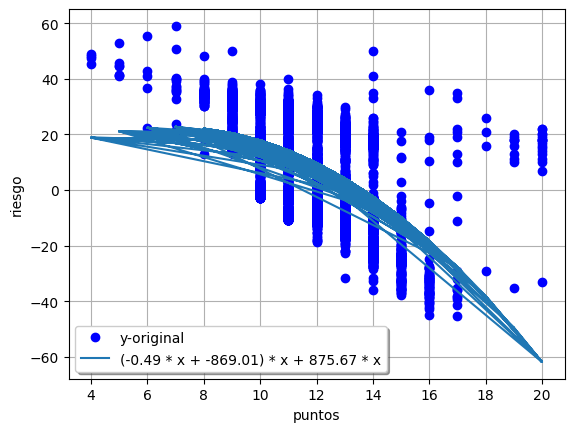

El valor de R2 es de: 0.2676376020038681
El valor de la correlación es de: 0.5173370294149339


In [25]:
modelo1(Var_dep1, Vars_Indep1)
modelo2(Var_dep1, Vars_Indep1)
modelo3(Var_dep1, Vars_Indep1)
modelo4(Var_dep1, Vars_Indep1)
modelo5(Var_dep1, Vars_Indep1)

###Descuento vs Score buro

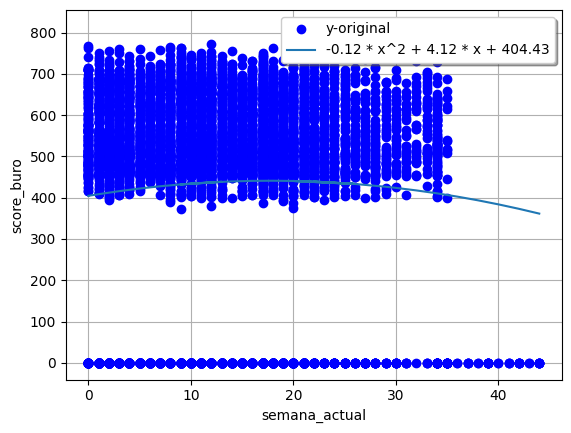

El valor de R2 es de: 0.002273914498664653
El valor de la correlación es de: 0.047685579567251286


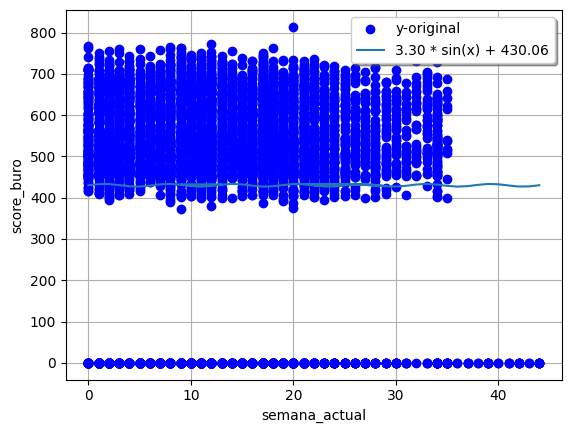

El valor de R2 es de: 9.138305880618258e-05
El valor de la correlación es de: 0.00955944866643378


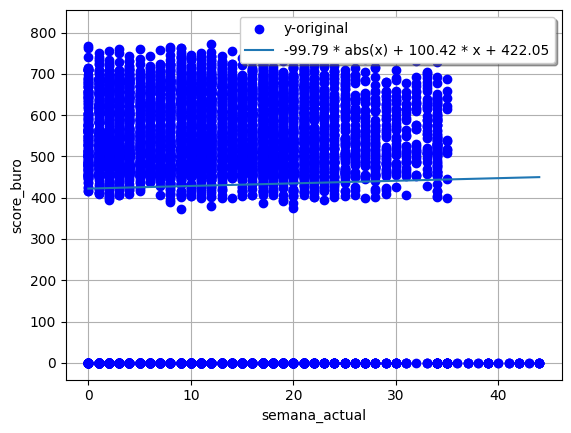

El valor de R2 es de: 0.000460962000233045
El valor de la correlación es de: 0.02147002562255213


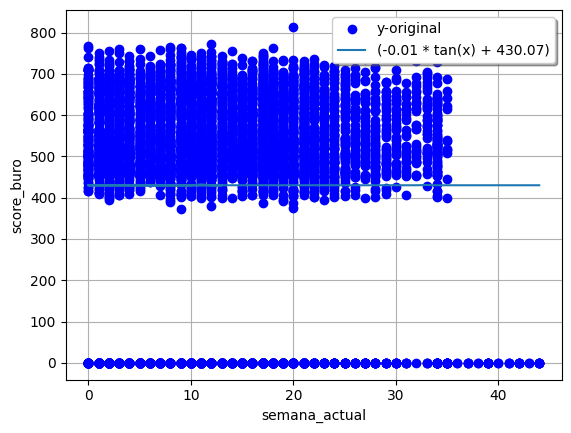

El valor de R2 es de: 2.577787213686733e-06
El valor de la correlación es de: 0.001605548882372235


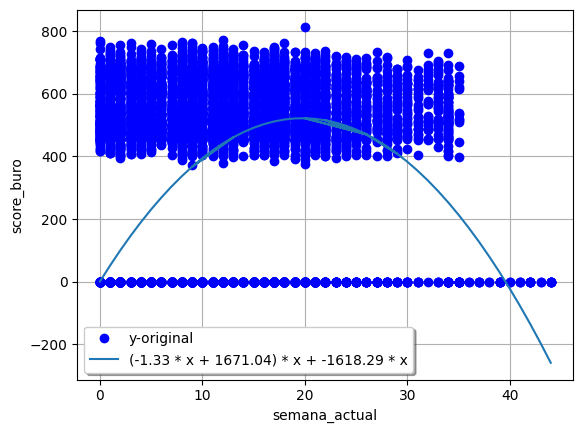

El valor de R2 es de: -0.43476480034184894
El valor de la correlación es de: 0.659366969404632


In [26]:
modelo1(Var_dep2, Vars_Indep2)
modelo2(Var_dep2, Vars_Indep2)
modelo3(Var_dep2, Vars_Indep2)
modelo4(Var_dep2, Vars_Indep2)
modelo5(Var_dep2, Vars_Indep2)

###edad_cliente vs porc_eng

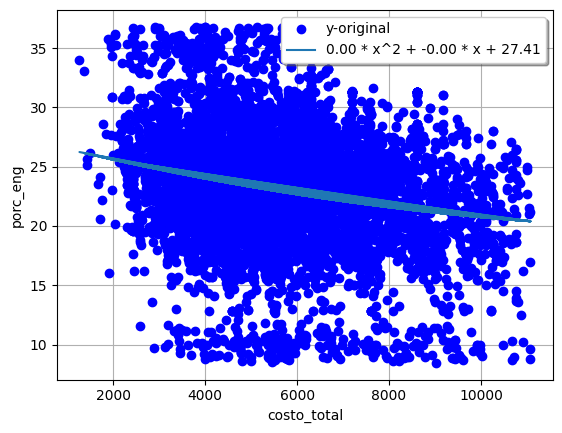

El valor de R2 es de: 0.052322567167669365
El valor de la correlación es de: 0.2287412668664519


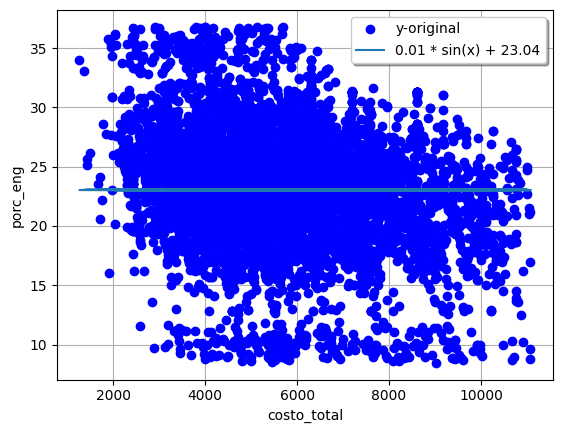

El valor de R2 es de: 2.7421637714963865e-06
El valor de la correlación es de: 0.0016559479978237198


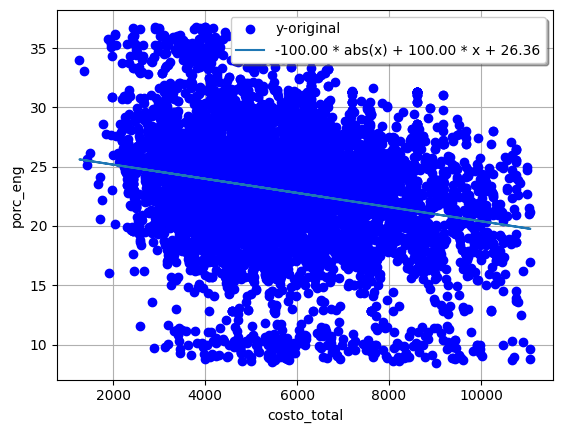

El valor de R2 es de: 0.051595218009427124
El valor de la correlación es de: 0.2271458078182979


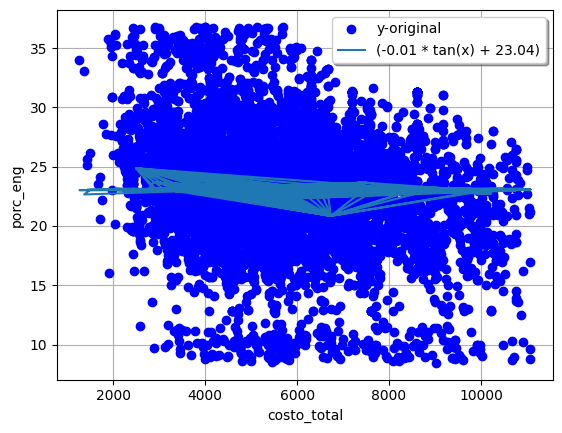

El valor de R2 es de: 0.0009940969123014565
El valor de la correlación es de: 0.03152930243918277


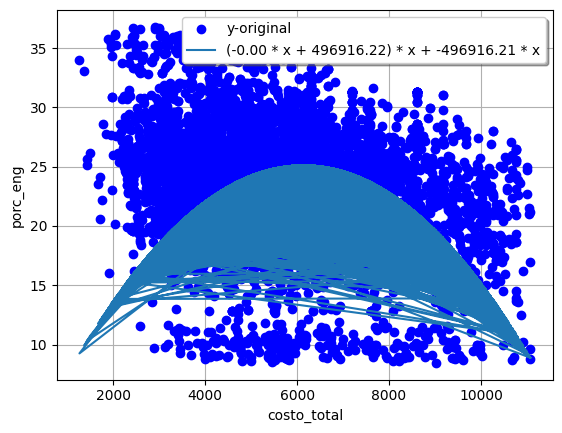

El valor de R2 es de: -0.3743789298643878
El valor de la correlación es de: 0.6118651239157106


In [27]:
modelo1(Var_dep3, Vars_Indep3)
modelo2(Var_dep3, Vars_Indep3)
modelo3(Var_dep3, Vars_Indep3)
modelo4(Var_dep3, Vars_Indep3)
modelo5(Var_dep3, Vars_Indep3)

###Monto financiado vs limite de credito

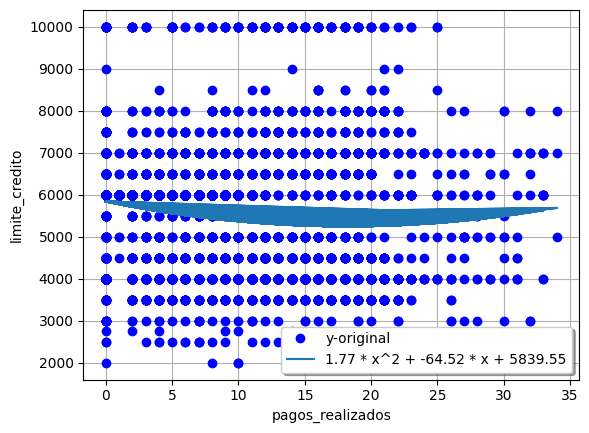

El valor de R2 es de: 0.02881778995135542
El valor de la correlación es de: 0.16975803353996363


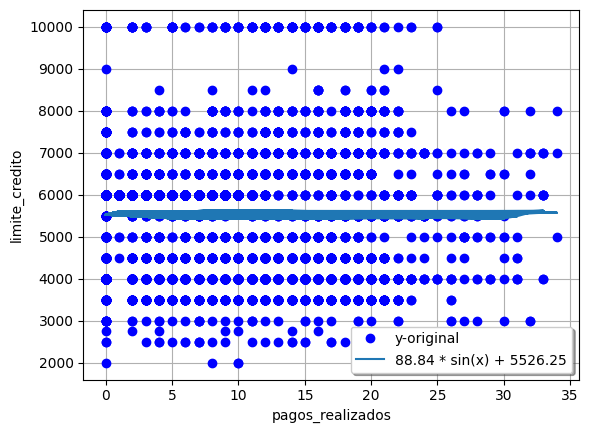

El valor de R2 es de: 0.002065848082340782
El valor de la correlación es de: 0.04545160153768822


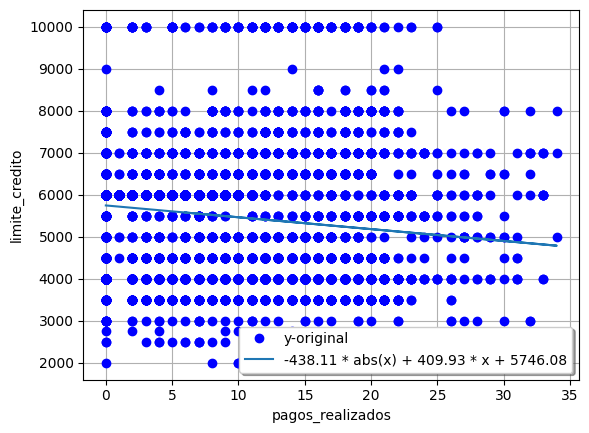

El valor de R2 es de: 0.02284843984140994
El valor de la correlación es de: 0.15115700394427622


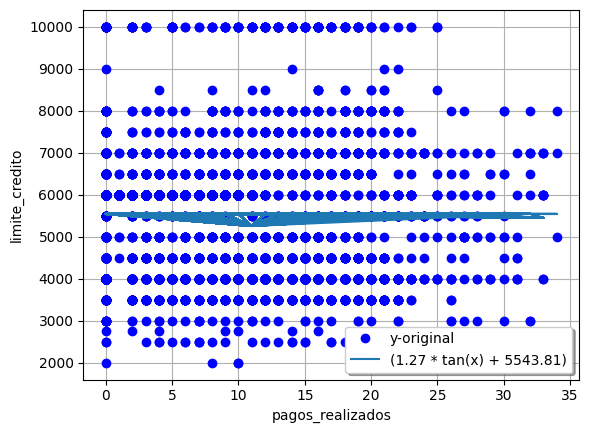

El valor de R2 es de: 0.0021235438272765306
El valor de la correlación es de: 0.04608192516894808


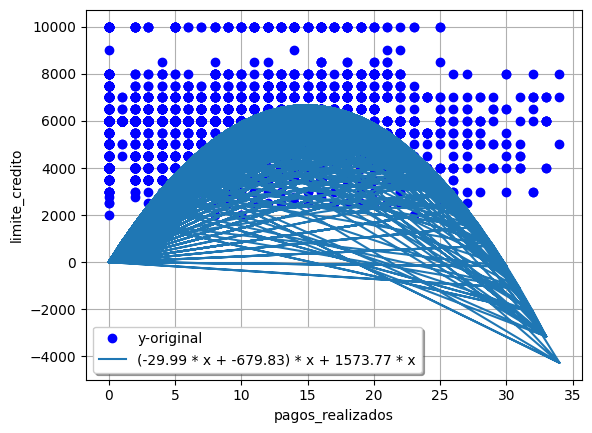

El valor de R2 es de: -6.679911290458286
El valor de la correlación es de: 2.58455243523096


In [28]:
modelo1(Var_dep4, Vars_Indep4)
modelo2(Var_dep4, Vars_Indep4)
modelo3(Var_dep4, Vars_Indep4)
modelo4(Var_dep4, Vars_Indep4)
modelo5(Var_dep4, Vars_Indep4)

##**Tabla de coeficientes de determinación**

In [29]:
print("Tabla de Coeficientes de Determinación:")
print("Var Depen| Var Indep | R-squared | Correlación")

for i in resultados:
    vardep, varindep, r_squared, corr = i
    print(f"  {vardep} | {varindep} | {r_squared:.4f} | {corr:.4f}")

Tabla de Coeficientes de Determinación:
Var Depen| Var Indep | R-squared | Correlación
  riesgo | puntos | 0.3206 | 0.5662
  riesgo | puntos | 0.0531 | 0.2305
  riesgo | puntos | 0.3173 | 0.5633
  riesgo | puntos | 0.0297 | 0.1725
  riesgo | puntos | 0.2676 | 0.5173
  score_buro | semana_actual | 0.0023 | 0.0477
  score_buro | semana_actual | 0.0001 | 0.0096
  score_buro | semana_actual | 0.0005 | 0.0215
  score_buro | semana_actual | 0.0000 | 0.0016
  score_buro | semana_actual | -0.4348 | 0.6594
  porc_eng | costo_total | 0.0523 | 0.2287
  porc_eng | costo_total | 0.0000 | 0.0017
  porc_eng | costo_total | 0.0516 | 0.2271
  porc_eng | costo_total | 0.0010 | 0.0315
  porc_eng | costo_total | -0.3744 | 0.6119
  limite_credito | pagos_realizados | 0.0288 | 0.1698
  limite_credito | pagos_realizados | 0.0021 | 0.0455
  limite_credito | pagos_realizados | 0.0228 | 0.1512
  limite_credito | pagos_realizados | 0.0021 | 0.0461
  limite_credito | pagos_realizados | -6.6799 | 2.5846
